# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import datetime
import re
import logging
from collections import OrderedDict
import multiprocessing
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM


Using TensorFlow backend.


In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
THIS_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

In [4]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [5]:
print(ROOT_DIR)
print(THIS_DIR)

C:\Users\TaisukeIto\Mask_RCNN
C:\Users\TaisukeIto\Mask_RCNN\samples3


In [6]:
class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """
    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = None  # Override in sub-classes

    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet101"

    # Only useful if you supply a callable to BACKBONE. Should compute
    # the shape of each layer of the FPN Pyramid.
    # See model.compute_backbone_shapes
    COMPUTE_BACKBONE_SHAPE = None

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Size of the fully-connected layers in the classification graph
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024

    # Size of the top-down layers used to build the feature pyramid
    TOP_DOWN_PYRAMID_SIZE = 256

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # Override in sub-classes

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 1

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    
    # ROIs kept after tf.nn.top_k and before non-maximum suppression
    PRE_NMS_LIMIT = 6000

    # ROIs kept after non-maximum suppression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Minimum scaling ratio. Checked after MIN_IMAGE_DIM and can force further
    # up scaling. For example, if set to 2 then images are scaled up to double
    # the width and height, or more, even if MIN_IMAGE_DIM doesn't require it.
    # However, in 'square' mode, it can be overruled by IMAGE_MAX_DIM.
    IMAGE_MIN_SCALE = 0
    # Number of color channels per image. RGB = 3, grayscale = 1, RGB-D = 4
    # Changing this requires other changes in the code. See the WIKI for more
    # details: https://github.com/matterport/Mask_RCNN/wiki
    IMAGE_CHANNEL_COUNT = 3

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 200

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14

    # Shape of output mask
    # To change this you also need to change the neural network mask branch
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True

    # Train or freeze batch normalization layers
    #     None: Train BN layers. This is the normal mode
    #     False: Freeze BN layers. Good when using a small batch size
    #     True: (don't use). Set layer in training mode even when predicting
    TRAIN_BN = False  # Defaulting to False since batch size is often small

    # Gradient norm clipping
    GRADIENT_CLIP_NORM = 5.0

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        if self.IMAGE_RESIZE_MODE == "crop":
            self.IMAGE_SHAPE = np.array([self.IMAGE_MIN_DIM, self.IMAGE_MIN_DIM,
                self.IMAGE_CHANNEL_COUNT])
        else:
            self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM,
                self.IMAGE_CHANNEL_COUNT])

        # Image meta data length
        # See compose_image_meta() for details
        self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")


In [7]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

In [8]:
class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
############################################################
#  Feature Pyramid Network Heads
############################################################
def build_fpn_mask_graph(rois, feature_maps, image_meta, pool_size, num_classes, train_bn=True):
    """Builds the computation graph of the mask head of Feature Pyramid Network.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized coordinates.
    feature_maps: List of feature maps from different layers of the pyramid, [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers

    Returns: Masks [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, NUM_CLASSES]
    """
    # ROI Pooling
    # Shape: [batch, num_rois, MASK_POOL_SIZE, MASK_POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size], name="roi_align_mask")([rois, image_meta] + feature_maps)

    # Conv layers
    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"), name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"), name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"), name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"), name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"), name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"), name="mrcnn_mask")(x)
    return x


In [10]:
############################################################
#  Detection Layer
############################################################
def refine_detections_graph(rois, probs, deltas, window, config):
    """Refine classified proposals and filter overlaps and return final detections.
    Inputs:
        rois: [N, (y1, x1, y2, x2)] in normalized coordinates
        probs: [N, num_classes]. Class probabilities.
        deltas: [N, num_classes, (dy, dx, log(dh), log(dw))]. Class-specific bounding box deltas.
        window: (y1, x1, y2, x2) in normalized coordinates. The part of the image that contains the image excluding the padding.
    Returns detections shaped: [num_detections, (y1, x1, y2, x2, class_id, score)] where coordinates are normalized.
    """
    # Class IDs per ROI
    class_ids = tf.argmax(probs, axis=1, output_type=tf.int32)
    # Class probability of the top class of each ROI
    indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1)
    class_scores = tf.gather_nd(probs, indices)
    # Class-specific bounding box deltas
    deltas_specific = tf.gather_nd(deltas, indices)
    # Apply bounding box deltas
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois = apply_box_deltas_graph(rois, deltas_specific * config.BBOX_STD_DEV)
    # Clip boxes to image window
    refined_rois = clip_boxes_graph(refined_rois, window)

    # TODO: Filter out boxes with zero area

    # Filter out background boxes
    keep = tf.where(class_ids > 0)[:, 0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        conf_keep = tf.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[:, 0]
        keep = tf.sets.set_intersection(tf.expand_dims(keep, 0), tf.expand_dims(conf_keep, 0))
        keep = tf.sparse_tensor_to_dense(keep)[0]

    # Apply per-class NMS
    # 1. Prepare variables
    pre_nms_class_ids = tf.gather(class_ids, keep)
    pre_nms_scores = tf.gather(class_scores, keep)
    pre_nms_rois = tf.gather(refined_rois,   keep)
    unique_pre_nms_class_ids = tf.unique(pre_nms_class_ids)[0]

    def nms_keep_map(class_id):
        """Apply Non-Maximum Suppression on ROIs of the given class."""
        # Indices of ROIs of the given class
        ixs = tf.where(tf.equal(pre_nms_class_ids, class_id))[:, 0]
        # Apply NMS
        class_keep = tf.image.non_max_suppression(tf.gather(pre_nms_rois, ixs), tf.gather(pre_nms_scores, ixs),max_output_size=config.DETECTION_MAX_INSTANCES,iou_threshold=config.DETECTION_NMS_THRESHOLD)
        # Map indices
        class_keep = tf.gather(keep, tf.gather(ixs, class_keep))
        # Pad with -1 so returned tensors have the same shape
        gap = config.DETECTION_MAX_INSTANCES - tf.shape(class_keep)[0]
        class_keep = tf.pad(class_keep, [(0, gap)], mode='CONSTANT', constant_values=-1)
        # Set shape so map_fn() can infer result shape
        class_keep.set_shape([config.DETECTION_MAX_INSTANCES])
        return class_keep

    # 2. Map over class IDs
    nms_keep = tf.map_fn(nms_keep_map, unique_pre_nms_class_ids, dtype=tf.int64)
    # 3. Merge results into one list, and remove -1 padding
    nms_keep = tf.reshape(nms_keep, [-1])
    nms_keep = tf.gather(nms_keep, tf.where(nms_keep > -1)[:, 0])
    # 4. Compute intersection between keep and nms_keep
    keep = tf.sets.set_intersection(tf.expand_dims(keep, 0), tf.expand_dims(nms_keep, 0))
    keep = tf.sparse_tensor_to_dense(keep)[0]
    # Keep top detections
    roi_count = config.DETECTION_MAX_INSTANCES
    class_scores_keep = tf.gather(class_scores, keep)
    num_keep = tf.minimum(tf.shape(class_scores_keep)[0], roi_count)
    top_ids = tf.nn.top_k(class_scores_keep, k=num_keep, sorted=True)[1]
    keep = tf.gather(keep, top_ids)

    # Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    # Coordinates are normalized.
    detections = tf.concat([tf.gather(refined_rois, keep), tf.to_float(tf.gather(class_ids, keep))[..., tf.newaxis], tf.gather(class_scores, keep)[..., tf.newaxis]], axis=1)

    # Pad with zeros if detections < DETECTION_MAX_INSTANCES
    gap = config.DETECTION_MAX_INSTANCES - tf.shape(detections)[0]
    detections = tf.pad(detections, [(0, gap), (0, 0)], "CONSTANT")
    return detections



In [11]:
############################################################
#  Miscellenous Graph Functions
############################################################
def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized coordinates it's inside the box.
    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


In [12]:
############################################################
#  Detection Layer
############################################################
class DetectionLayer(KE.Layer):
    """Takes classified proposal boxes and their bounding box deltas and returns the final detection boxes.
    Returns:
    [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] where coordinates are normalized.
    """

    def __init__(self, config=None, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)
        self.config = config

    def call(self, inputs):
        rois = inputs[0]
        mrcnn_class = inputs[1]
        mrcnn_bbox = inputs[2]
        image_meta = inputs[3]

        # Get windows of images in normalized coordinates. Windows are the area
        # in the image that excludes the padding.
        # Use the shape of the first image in the batch to normalize the window
        # because we know that all images get resized to the same size.
        m = parse_image_meta_graph(image_meta)
        image_shape = m['image_shape'][0]
        window = norm_boxes_graph(m['window'], image_shape[:2])

        # Run detection refinement graph on each item in the batch
        detections_batch = utils.batch_slice([rois, mrcnn_class, mrcnn_bbox, window], lambda x, y, w, z: refine_detections_graph(x, y, w, z, self.config), self.config.IMAGES_PER_GPU)

        # Reshape output
        # [batch, num_detections, (y1, x1, y2, x2, class_id, class_score)] in
        # normalized coordinates
        return tf.reshape(detections_batch, [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])

    def compute_output_shape(self, input_shape):
        return (None, self.config.DETECTION_MAX_INSTANCES, 6)


In [13]:
############################################################
#  Data Formatting
############################################################
def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.

    meta: [batch, meta length] where meta length depends on NUM_CLASSES

    Returns a dict of the parsed tensors.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }


In [14]:
def log2_graph(x):
    """Implementation of Log2. TF doesn't have a native implementation."""
    return tf.log(x) / tf.log(2.0)


In [15]:
############################################################
#  ROIAlign Layer
############################################################
class PyramidROIAlign(KE.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.

    Params:
    - pool_shape: [pool_height, pool_width] of the output pooled regions. Usually [7, 7]

    Inputs:
    - boxes: [batch, num_boxes, (y1, x1, y2, x2)] in normalized coordinates. 
              Possibly padded with zeros if not enough boxes to fill the array.
    - image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    - feature_maps: List of feature maps from different levels of the pyramid.
                    Each is [batch, height, width, channels]

    Output:
    Pooled regions in the shape: [batch, num_boxes, pool_height, pool_width, channels].
    The width and height are those specific in the pool_shape in the layer constructor.
    """

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def call(self, inputs):
        # Crop boxes [batch, num_boxes, (y1, x1, y2, x2)] in normalized coords
        boxes = inputs[0]

        # Image meta
        # Holds details about the image. See compose_image_meta()
        image_meta = inputs[1]

        # Feature Maps. List of feature maps from different level of the
        # feature pyramid. Each is [batch, height, width, channels]
        feature_maps = inputs[2:]

        # Assign each ROI to a level in the pyramid based on the ROI area.
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1
        # Use shape of first image. Images in a batch must have the same size.
        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]
        # Equation 1 in the Feature Pyramid Networks paper. Account for
        # the fact that our coordinates are normalized here.
        # e.g. a 224x224 ROI (in pixels) maps to P4
        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        # Loop through levels and apply ROI pooling to each. P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize
            # From Mask R-CNN paper: "We sample four regular locations, so
            # that we can evaluate either max or average pooling. In fact,
            # interpolating only a single value at each bin center (without
            # pooling) is nearly as effective."
            #
            # Here we use the simplified approach of a single value per bin,
            # which is how it's done in tf.crop_and_resize()
            # Result: [batch * num_boxes, pool_height, pool_width, channels]
            pooled.append(tf.image.crop_and_resize(feature_maps[i], level_boxes, box_indices, self.pool_shape, method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range], axis=1)

        # Rearrange pooled features to match the order of the original boxes
        # Sort box_to_level by batch then box index
        # TF doesn't have a way to sort by two columns, so merge them and sort.
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(boxes)[:2], tf.shape(pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )



In [16]:
############################################################
#  Feature Pyramid Network Heads
############################################################
def fpn_classifier_graph(rois, feature_maps, image_meta, pool_size, num_classes, train_bn=True, fc_layers_size=1024):
    """Builds the computation graph of the feature pyramid network classifier and regressor heads.

    rois: [batch, num_rois, (y1, x1, y2, x2)] Proposal boxes in normalized coordinates.
    feature_maps: List of feature maps from different layers of the pyramid, [P2, P3, P4, P5]. Each has a different resolution.
    image_meta: [batch, (meta data)] Image details. See compose_image_meta()
    pool_size: The width of the square feature map generated from ROI Pooling.
    num_classes: number of classes, which determines the depth of the results
    train_bn: Boolean. Train or freeze Batch Norm layers
    fc_layers_size: Size of the 2 FC layers

    Returns:
        logits: [batch, num_rois, NUM_CLASSES] classifier logits (before softmax)
        probs: [batch, num_rois, NUM_CLASSES] classifier probabilities
        bbox_deltas: [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))] Deltas to apply to proposal boxes
    """
    # ROI Pooling
    # Shape: [batch, num_rois, POOL_SIZE, POOL_SIZE, channels]
    x = PyramidROIAlign([pool_size, pool_size], name="roi_align_classifier")([rois, image_meta] + feature_maps)
    # Two 1024 FC layers (implemented with Conv2D for consistency)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"), name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)), name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2), name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes), name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"), name="mrcnn_class")(mrcnn_class_logits)

    # BBox head
    # [batch, num_rois, NUM_CLASSES * (dy, dx, log(dh), log(dw))]
    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'), name='mrcnn_bbox_fc')(shared)
    # Reshape to [batch, num_rois, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
    s = K.int_shape(x)
    mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox


In [17]:
############################################################
#  Proposal Layer
############################################################
def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped

In [18]:
############################################################
#  Proposal Layer
############################################################
def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result

In [19]:
class ProposalLayer(KE.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.

    Inputs:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates

    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True, name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y), self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y), self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x), self.config.IMAGES_PER_GPU, names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = utils.batch_slice([pre_nms_anchors, deltas], lambda x, y: apply_box_deltas_graph(x, y), self.config.IMAGES_PER_GPU, names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes, lambda x: clip_boxes_graph(x, window), self.config.IMAGES_PER_GPU, names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(boxes, scores, self.proposal_count, self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms, self.config.IMAGES_PER_GPU)
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)


In [20]:
def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the feature map
    # is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu', strides=anchor_stride, name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid', activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation("softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid", activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]

In [21]:
def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth], name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")


In [22]:
def identity_block(input_tensor, kernel_size, filters, stage, block, use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


In [23]:
def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides, name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides, name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


In [24]:
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.
    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


In [25]:
def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created train_bn: Boolean. 
        Train or freeze Batch Norm layers
    """
    assert architecture in ["resnet50", "resnet101"]
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]

In [26]:
class MaskRCNN():

    def __init__(self, mode, config, model_dir):
        """
        mode: Either "training" or "inference"
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        """Build Mask R-CNN architecture.
            input_shape: The shape of the input image.
            mode: Either "training" or "inference". The inputs and outputs of the model differ accordingly.
        """
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]

        # Inputs
        input_image = KL.Input(shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")

        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE], name="input_image_meta")
        
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(shape=[config.MINI_MASK_SHAPE[0], config.MINI_MASK_SHAPE[1], None], name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None], name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True, train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE, stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5), KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4), KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3), KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            # A hack to get around Keras's bad support for constants
            anchors = KL.Lambda(lambda x: tf.Variable(anchors), name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE, len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o)) for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(proposal_count=proposal_count, nms_threshold=config.RPN_NMS_THRESHOLD, name="ROI", config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(lambda x: parse_image_meta_graph(x)["active_class_ids"])(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4], name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_bbox, target_mask = DetectionTargetLayer(config, name="proposal_targets")([target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            # TODO: verify that this handles zero padded ROIs
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta, config.POOL_SIZE, config.NUM_CLASSES, train_bn=config.TRAIN_BN, fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps, input_image_meta, config.MASK_POOL_SIZE, config.NUM_CLASSES, train_bn=config.TRAIN_BN)

            # TODO: clean up (use tf.identify if necessary)
            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")([input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")([input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")([target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")([target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")([target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta, input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox, mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask, rpn_rois, output_rois, rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta, config.POOL_SIZE, config.NUM_CLASSES, train_bn=config.TRAIN_BN, fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
            # normalized coordinates
            detections = DetectionLayer(config, name="mrcnn_detection")([rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps, input_image_meta, config.MASK_POOL_SIZE, config.NUM_CLASSES, train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors], [detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox], name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            import errno
            raise FileNotFoundError(errno.ENOENT, "Could not find model directory under {}".format(self.model_dir))
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the corresponding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exclude: list of layer names to exclude
        """
        import h5py
        # Conditional import to support versions of Keras before 2.2
        # TODO: remove in about 6 months (end of 2018)
        try:
            from keras.engine import saving
        except ImportError:
            # Keras before 2.2 used the 'topology' namespace.
            from keras.engine import topology as saving

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        f = h5py.File(filepath, mode='r')
        if 'layer_names' not in f.attrs and 'model_weights' in f:
            f = f['model_weights']

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        keras_model = self.keras_model
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model") else keras_model.layers

        # Exclude some layers
        if exclude:
            layers = filter(lambda l: l.name not in exclude, layers)

        if by_name:
            saving.load_weights_from_hdf5_group_by_name(f, layers)
        else:
            saving.load_weights_from_hdf5_group(f, layers)
        if hasattr(f, 'close'):
            f.close()

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_WEIGHTS_PATH_NO_TOP, cache_subdir='models', md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = ["rpn_class_loss",  "rpn_bbox_loss", "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (tf.reduce_mean(layer.output, keepdims=True) * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.metrics_tensors.append(loss)

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainable layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.

        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # \path\to\logs\coco20171029T2315\mask_rcnn_coco_0001.h5 (Windows)
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5 (Linux)
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            m = re.match(regex, model_path)
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                # Epoch number in file is 1-based, and in Keras code it's 0-based.
                # So, adjust for that then increment by one to start from the next epoch
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.

                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        no_augmentation_sources: Optional. List of sources to exclude for
            augmentation. A source is string that identifies a dataset and is
            defined in the Dataset class.
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name is 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1) if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.
        images: List of images, potentially of different sizes.
        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already. Used mostly for debugging and inspecting
        the model.

        molded_images: List of images loaded using load_image_gt()
        image_metas: image meta data, also returned by load_image_gt()

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph that computes the given
        outputs.

        image_metas: If provided, the images are assumed to be already
            molded (i.e. resized, padded, and normalized)

        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.

        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


## Create Model and Load Trained Weights

In [27]:
# Create model object in inference mode.
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.


In [28]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [29]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [30]:
############################################################
#  Utility Functions
############################################################
def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)


In [31]:
def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL

In [32]:
############################################################
#  Data Formatting
############################################################
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta


In [33]:
def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.

    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array([[int(math.ceil(image_shape[0] / stride)), int(math.ceil(image_shape[1] / stride))] for stride in config.BACKBONE_STRIDES])


In [34]:
import colorsys
from matplotlib import patches,  lines
from skimage.measure import find_contours
from matplotlib.patches import Polygon

In [35]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1, image[:, :, c] * (1 - alpha) + alpha * color[c] * 255, image[:, :, c])
    return image


In [36]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


In [37]:
def display_instances(image, boxes, masks, class_ids, class_names, scores=None, title="", figsize=(16, 16), ax=None, show_mask=True, show_bbox=True, colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7, linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()



In [38]:
# Load a random image from the images folder
file_names = os.path.join(ROOT_DIR, "test1.jpg")
print(file_names)
image = skimage.io.imread(file_names)

# Run detection
results = model.detect([image], verbose=1)

C:\Users\TaisukeIto\Mask_RCNN\test1.jpg
Processing 1 images
image                    shape: (480, 640, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



In [39]:
# Visualize results
r = results[0]

In [40]:
import numpy as np
print(type(np.array(r['masks'])))
print(np.array(r['masks']).shape)

<class 'numpy.ndarray'>
(480, 640, 5)


In [41]:
print(type(np.array(r['class_ids'])))
print(np.array(r['class_ids']).shape)
print(np.array(r['class_ids']))

<class 'numpy.ndarray'>
(5,)
[ 1 28 75  1 57]


In [42]:
print(type(np.array(r['scores'])))
print(np.array(r['scores']).shape)
print(np.array(r['scores']))

<class 'numpy.ndarray'>
(5,)
[0.9999788 0.9991008 0.9986455 0.9920025 0.9847067]


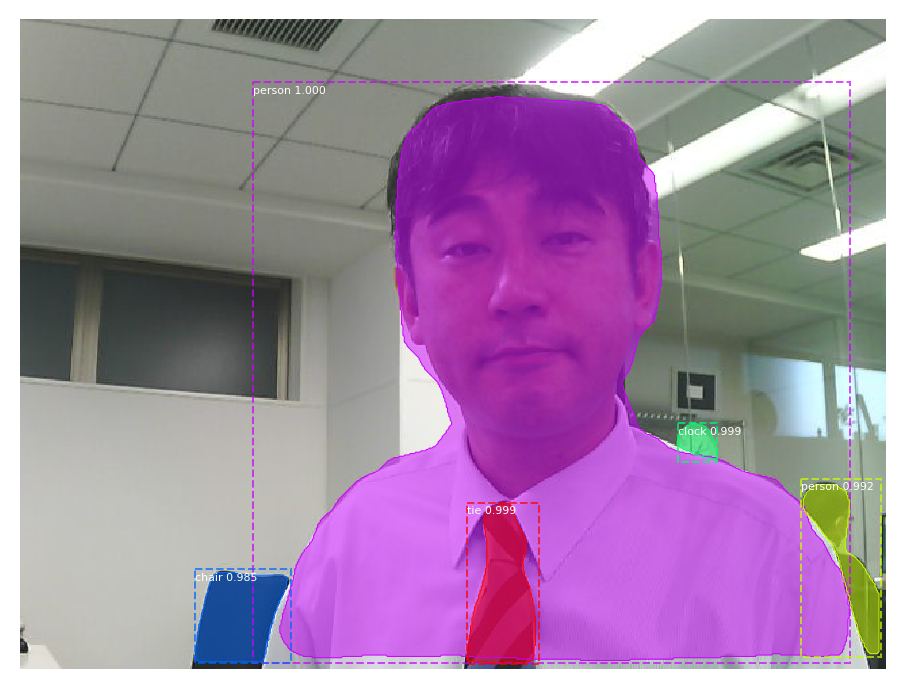

In [43]:
display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
